<a href="https://colab.research.google.com/github/Maruf346/AI-ML-with-python/blob/main/Transfer_Learning_with_Pretrained_Model_with_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use transfer learning with pretrained models like ResNet or VGG.**


Tasks:

1. Load a pretrained model using torchvision.models.


2. Replace the final layer with a new classifier (e.g., 2 classes).


3. Freeze earlier layers, train only the classifier.


4. Evaluate performance.

100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


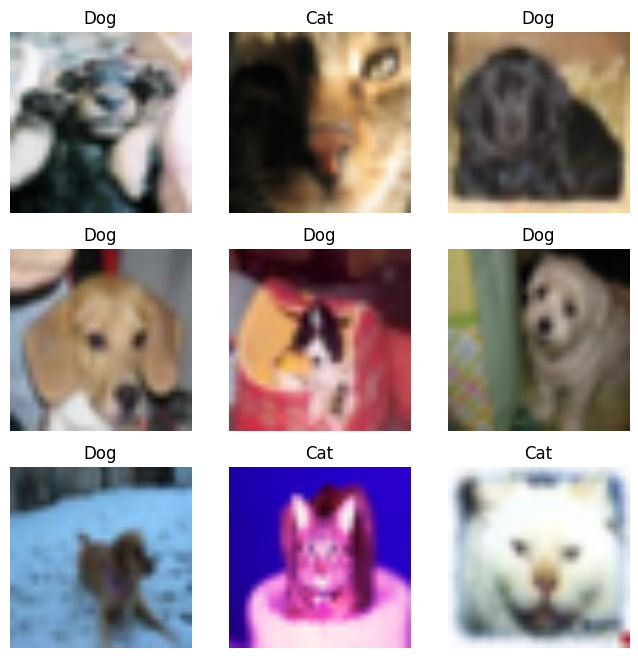

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


Epoch [1/5] - Train Acc: 78.87% | Test Acc: 82.75%
Epoch [2/5] - Train Acc: 82.49% | Test Acc: 82.05%
Epoch [3/5] - Train Acc: 82.90% | Test Acc: 81.50%
Epoch [4/5] - Train Acc: 82.87% | Test Acc: 82.45%
Epoch [5/5] - Train Acc: 83.33% | Test Acc: 82.65%


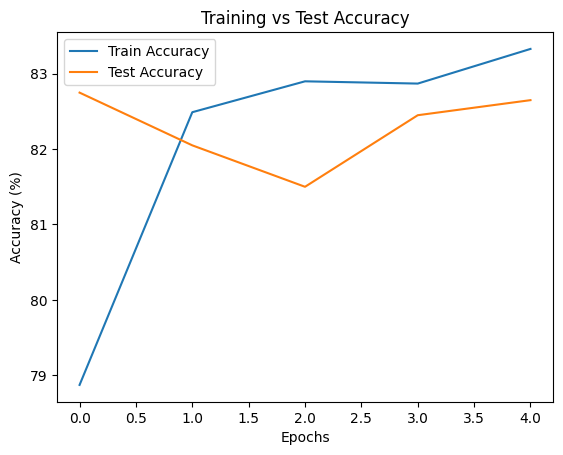

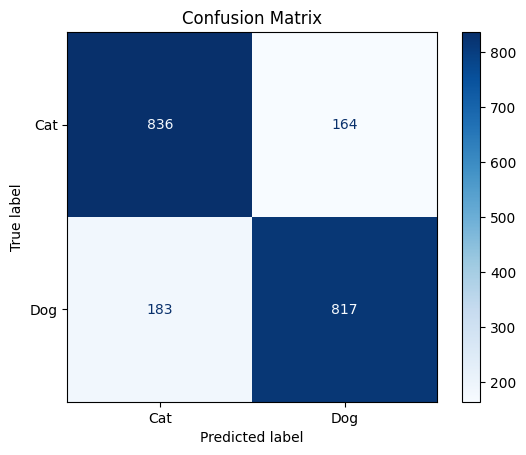

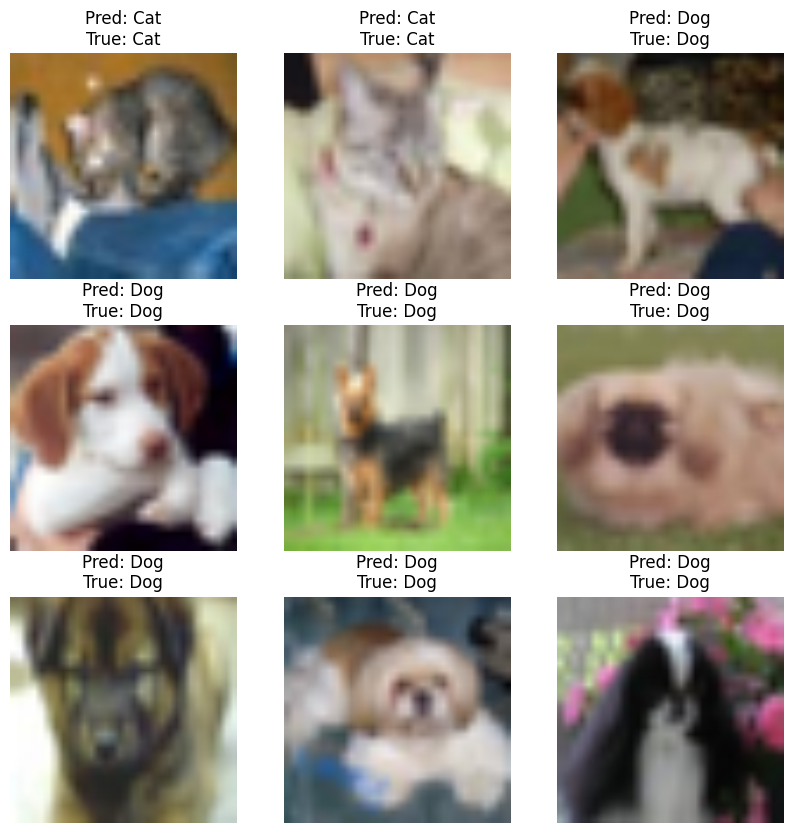

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------
# Data Preparation
# --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 and filter cats(3) & dogs(5)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cat_dog_classes = [3, 5]
trainset.targets = torch.tensor(trainset.targets)
testset.targets = torch.tensor(testset.targets)

train_mask = (trainset.targets == 3) | (trainset.targets == 5)
test_mask = (testset.targets == 3) | (testset.targets == 5)

trainset.data = trainset.data[train_mask]
trainset.targets = trainset.targets[train_mask]
testset.data = testset.data[test_mask]
testset.targets = testset.targets[test_mask]

# Map 3 -> 0 (cat), 5 -> 1 (dog)
trainset.targets = (trainset.targets == 5).long()
testset.targets = (testset.targets == 5).long()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

class_names = ["Cat", "Dog"]

# --------------------
# Show sample images
# --------------------
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize (if needed)
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis("off")

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(images[i], class_names[labels[i]])
plt.show()

# --------------------
# Model Setup
# --------------------
from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze feature extractor

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat, dog

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# --------------------
# Training
# --------------------
train_acc_list = []
test_acc_list = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# --------------------
# Plot Accuracy Curves
# --------------------
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.show()

# --------------------
# Confusion Matrix
# --------------------
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --------------------
# Sample Predictions
# --------------------
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i].cpu(), f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
plt.show()
